## Purpose of Script

abc

In [1]:
import pandas as pd
import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import os
import time
from rdkit.Chem.MolStandardize import rdMolStandardize
from IPython.display import clear_output
import matplotlib.pyplot as plt
from multiprocessing import Pool, TimeoutError, Manager
from functools import partial
import pubchempy as pcp
import random
import json
import numpy as np
from tqdm import tqdm
from rdkit.Chem import PandasTools
from rdkit.Chem import rdmolops
from rdkit import RDConfig

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/paperspace/.local/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


### RDKit to Generate Morgan Fingerprints

In [2]:
# generate morgan fingerprint 2048 length vector - multiprocessing

def generate_morgan_fp(lst, compound_data):
    """
    Generate Morgan fingerprints for a given molecular compound represented by its
    isomeric SMILES notation. Update the compound_data list with the computed fingerprint
    and append it to the provided list.
    """

    # compound_data = list -> index 0 = inchi, index 1 = isomeric smile
    mol = Chem.MolFromSmiles(compound_data[1])
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, useChirality=True, radius=2, nBits = 2048)
    compound_data.append(fp.ToBitString()) # [inchi, iso_smile, fp]
    lst.append(compound_data) # list of lists
    pbar.update(1)

In [3]:
def remove_nulls_format(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
    """
    Remove rows with null or 'None' values from a specified column in a DataFrame,
    and convert the column to a float data type.
    """
    print(f"Size of input df: {len(df):,}")

    df=df[df[column_name]!='None']
    df=df.dropna(subset=column_name).reset_index(drop=True)
    df[column_name]=df[column_name].astype(float)

    return df

In [4]:
def create_graphs(df: pd.DataFrame, smiles_col: str) -> pd.DataFrame: 
    """
    Create graph representations for molecular structures based on SMILES notations
    using the DeepChem library's ConvMolFeaturizer.
    """
    featurizer=dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False) # if True takes forever and large memory
    f = featurizer.featurize(df[smiles_col])
    df['dc_graph'] = f

    return df

In [5]:
def load_drugbank() -> pd.DataFrame:
    """
    Load drug data from the DrugBank 3D structures SDF file and return a DataFrame.
    The DrugBank dataset contains information about drugs, including molecular structures.
    """
    file_name="/home/paperspace/Desktop/DL_Project/data/partial_archived/drugbank_3D_structures.sdf"

    sdfFile = os.path.join(file_name)
    frame = PandasTools.LoadSDF(sdfFile,smilesName='SMILES',molColName='Molecule',
            includeFingerprints=True)

    df=frame[['DATABASE_ID', "SMILES", "INCHI_KEY", 'DRUG_GROUPS', 'MOLECULAR_WEIGHT', 'GENERIC_NAME', 'Molecule']]

    df.columns=df.columns.str.lower()
    df.rename(columns={"inchi_key": "inchikey"}, inplace=True)

    print(f"Number of compounds in drugbank: {len(df):,}")
    display(df.head())
    return df
    

eval_drugbank=True

if eval_drugbank:
       drugbank=load_drugbank()

Number of compounds in drugbank: 9,468


/tmp/ipykernel_3517/2501419711.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"inchi_key": "inchikey"}, inplace=True)


,database_id,smiles,inchikey,drug_groups,molecular_weight,generic_name,molecule
0,DB00114,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,NGVDGCNFYWLIFO-UHFFFAOYSA-N,approved; investigational; nutraceutical,247.1419,Pyridoxal phosphate,<rdkit.Chem.rdchem.Mol object at 0x7fde55026cf0>
1,DB00116,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,nutraceutical,445.4292,Tetrahydrofolic acid,<rdkit.Chem.rdchem.Mol object at 0x7fde55026c10>
2,DB00117,N[C@@H](Cc1cnc[nH]1)C(=O)O,HNDVDQJCIGZPNO-YFKPBYRVSA-N,investigational; nutraceutical,155.1546,Histidine,<rdkit.Chem.rdchem.Mol object at 0x7fde55026f20>
3,DB00118,C[S@@+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2c...,MEFKEPWMEQBLKI-AIRLBKTGSA-N,approved; investigational; nutraceutical,398.44,Ademetionine,<rdkit.Chem.rdchem.Mol object at 0x7fde52ee4040>
4,DB00119,CC(=O)C(=O)O,LCTONWCANYUPML-UHFFFAOYSA-N,approved; investigational; nutraceutical,88.0621,Pyruvic acid,<rdkit.Chem.rdchem.Mol object at 0x7fde52ee4120>


In [6]:
def neutralize(df: pd.DataFrame, mol_column='molecule') -> pd.DataFrame:

    un = rdMolStandardize.Uncharger()

    df["charge"] = df[mol_column].apply(lambda x: rdmolops.GetFormalCharge(x))
    df['uncharged_mol']=df[mol_column].apply(lambda x: un.uncharge(x))
    df['uncharged_smiles']=df['uncharged_mol'].apply(lambda x: Chem.MolToSmiles(x))
    df["updated_charge"] = df['uncharged_mol'].apply(lambda x: rdmolops.GetFormalCharge(x))

    clear_output()
    display(df.head())

    return df


In [7]:
drugbank=neutralize(drugbank, 'molecule')

,database_id,smiles,inchikey,drug_groups,molecular_weight,generic_name,molecule,charge,uncharged_mol,uncharged_smiles,updated_charge
0,DB00114,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,NGVDGCNFYWLIFO-UHFFFAOYSA-N,approved; investigational; nutraceutical,247.1419,Pyridoxal phosphate,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a54a0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fb0074120b0>,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0
1,DB00116,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,nutraceutical,445.4292,Tetrahydrofolic acid,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a5660>,0,<rdkit.Chem.rdchem.Mol object at 0x7fb007412c80>,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,0
2,DB00117,N[C@@H](Cc1cnc[nH]1)C(=O)O,HNDVDQJCIGZPNO-YFKPBYRVSA-N,investigational; nutraceutical,155.1546,Histidine,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a56d0>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf391225f0>,N[C@@H](Cc1cnc[nH]1)C(=O)O,0
3,DB00118,C[S@@+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2c...,MEFKEPWMEQBLKI-AIRLBKTGSA-N,approved; investigational; nutraceutical,398.44,Ademetionine,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a57b0>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf392c6120>,C[S@@+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2c...,0
4,DB00119,CC(=O)C(=O)O,LCTONWCANYUPML-UHFFFAOYSA-N,approved; investigational; nutraceutical,88.0621,Pyruvic acid,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a5890>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf392c6c10>,CC(=O)C(=O)O,0


In [8]:
### Training Data - Remove Overlap

### Load Training Data to Remove Overlap with Prediction Set

In [16]:
pubchem=pd.read_pickle("/home/paperspace/Desktop/DL_Project/data/both_assays_pubchem_fp_chembl.pickle")
print(f"Length of pubchem training set: {len(pubchem):,}")
pubchem.head()

Length of pubchem training set: 264,965


,pubchem_cid,smiles,tau_inhibitor,app_inhibitor,inchi,inchikey,cmpdname,isosmiles,cmpdsynonym,mw,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,None,None
0,2227226,C1=CC=C(C=C1)OC(=O)C2=CC=CC3=C2N=CC=C3,Inactive,Inactive,InChI=1S/C16H11NO2/c18-16(19-13-8-2-1-3-9-13)1...,GPMDYHKFDVDMLK-UHFFFAOYSA-N,8-Quinolinecarboxylic acid phenyl ester,C1=CC=C(C=C1)OC(=O)C2=CC=CC3=C2N=CC=C3,phenyl quinoline-8-carboxylate|8-quinolinecarb...,249.26,...,19,3,0,0,249.0790,NEUTRAL,C16H11NO2,O=C(Oc1ccccc1)c1cccc2cccnc12,None,None
1,135420967,COC1=CC=C(C=C1)N=CC2=C(C3=CC=CC=C3OC2=O)O,Inactive,Inactive,InChI=1S/C17H13NO4/c1-21-12-8-6-11(7-9-12)18-1...,RUCHDIHJKMGHHH-UHFFFAOYSA-N,"3-[(4-methoxyanilino)methylene]-2H-chromene-2,...",COC1=CC=C(C=C1)N=CC2=C(C3=CC=CC=C3OC2=O)O,364602-08-4|AGN-PC-0LQKC2|Oprea1_586022|MLS000...,295.29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15945137,C1CCN(CC1)CC(=O)C2=CC=C(C=C2)OC(F)F.Br,Inactive,Inactive,InChI=1S/C14H17F2NO2.BrH/c15-14(16)19-12-6-4-1...,RBJGPSFQVZUNKQ-UHFFFAOYSA-N,1-[4-(Difluoromethoxy)phenyl]-2-piperidin-1-yl...,C1CCN(CC1)CC(=O)C2=CC=C(C=C2)OC(F)F.Br,MLS000392681|CHEMBL1301972|SMR000261595,350.20,...,19,3,0,0,269.1227,NEUTRAL,C14H18BrF2NO2,Br.O=C(CN1CCCCC1)c1ccc(OC(F)F)cc1,None,None
3,7191270,CCOC(=O)CNC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=C(C=C2)C,Inactive,Inactive,InChI=1S/C16H18N4O4S2/c1-3-24-13(22)8-17-12(21...,QICJAPDRGJFGEK-UHFFFAOYSA-N,"Ethyl 2-[[2-[[5-[(4-methylbenzoyl)amino]-1,3,4...",CCOC(=O)CNC(=O)CSC1=NN=C(S1)NC(=O)C2=CC=C(C=C2)C,MLS000624325|893337-54-7|SMR000323633|ethyl 2-...,394.50,...,26,8,2,0,394.0769,NEUTRAL,C16H18N4O4S2,CCOC(=O)CNC(=O)CSc1nnc(NC(=O)c2ccc(C)cc2)s1,None,None
4,1356333,C1CN(CCN1C2=CC=CC=C2)S(=O)(=O)C3=CC=CC4=C3N=CC=C4,Inactive,Inactive,"InChI=1S/C19H19N3O2S/c23-25(24,18-10-4-6-16-7-...",JFJQCQAUBVYCLI-UHFFFAOYSA-N,4-Phenyl-1-(8-quinolylsulfonyl)piperazine,C1CN(CCN1C2=CC=CC=C2)S(=O)(=O)C3=CC=CC4=C3N=CC=C4,4-PHENYL-1-(8-QUINOLYLSULFONYL)PIPERAZINE|3247...,353.40,...,25,5,0,0,353.1198,NEUTRAL,C19H19N3O2S,O=S(=O)(c1cccc2cccnc12)N1CCN(c2ccccc2)CC1,None,None


In [12]:
drugbank_overlap=drugbank.merge(pubchem, how='inner', on='inchikey')
drugbank_overlap=drugbank_overlap[['database_id']]
drugbank_overlap['in_pubchem']=True

In [14]:
drugbank=drugbank.merge(drugbank_overlap, how='left', on='database_id')
drugbank['in_pubchem'].fillna(False, inplace=True)
drugbank=drugbank[drugbank['in_pubchem']==False].reset_index(drop=True)

In [17]:
print(f"Length of filtered drugbank set: {len(drugbank):,}")
drugbank.head()

Length of filtered drugbank set: 8,334


,database_id,smiles,inchikey,drug_groups,molecular_weight,generic_name,molecule,charge,uncharged_mol,uncharged_smiles,updated_charge,in_pubchem
0,DB00114,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,NGVDGCNFYWLIFO-UHFFFAOYSA-N,approved; investigational; nutraceutical,247.1419,Pyridoxal phosphate,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a54a0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fb0074120b0>,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0,False
1,DB00116,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,nutraceutical,445.4292,Tetrahydrofolic acid,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a5660>,0,<rdkit.Chem.rdchem.Mol object at 0x7fb007412c80>,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,0,False
2,DB00117,N[C@@H](Cc1cnc[nH]1)C(=O)O,HNDVDQJCIGZPNO-YFKPBYRVSA-N,investigational; nutraceutical,155.1546,Histidine,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a56d0>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf391225f0>,N[C@@H](Cc1cnc[nH]1)C(=O)O,0,False
3,DB00118,C[S@@+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2c...,MEFKEPWMEQBLKI-AIRLBKTGSA-N,approved; investigational; nutraceutical,398.44,Ademetionine,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a57b0>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf392c6120>,C[S@@+](CC[C@H](N)C(=O)[O-])C[C@H]1O[C@@H](n2c...,0,False
4,DB00119,CC(=O)C(=O)O,LCTONWCANYUPML-UHFFFAOYSA-N,approved; investigational; nutraceutical,88.0621,Pyruvic acid,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a5890>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf392c6c10>,CC(=O)C(=O)O,0,False


In [18]:
print("original charge distribution of drugbank molecules:")
display(pd.DataFrame(drugbank['charge'].value_counts()).sort_index())
print("uncharged charge distribution of drugbank molecules")
display(pd.DataFrame(drugbank['updated_charge'].value_counts()))

original charge distribution of drugbank molecules:


,charge
-4,1
-3,8
-2,15
-1,39
0,8085
1,171
2,14
3,1


uncharged charge distribution of drugbank molecules


,updated_charge
0,8206
1,119
2,9


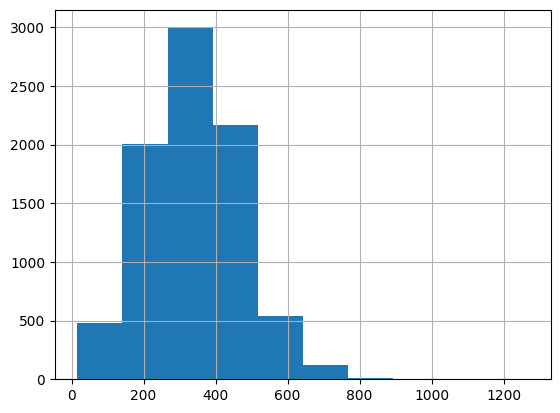

In [19]:
### large majority are less than 600
valid_mws=drugbank['molecular_weight'].dropna()
valid_mws.astype(float).hist()
plt.show()

In [20]:
pd.DataFrame(drugbank['drug_groups'].value_counts()).head()

,drug_groups
experimental,4592
investigational,2003
approved; investigational,521
approved,506
experimental; illicit,91


In [21]:
# parallelize generation
fp_function_columns = drugbank[['inchikey', 'uncharged_smiles']].values.tolist()

# print("First two elements of list:")
# fp_function_columns[:2]

if __name__ == '__main__':

    pbar = tqdm(total=len(drugbank)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_morgan_fp, dfs_list), fp_function_columns)
    res.wait()
    pbar.close()

  0%|          | 0/1041.75 [00:01<?, ?it/s] 966.34it/s]]


In [22]:
fp_df = pd.DataFrame(list(dfs_list), columns=['inchikey', 'uncharged_smiles', 'morgan_fp'])  # the final result
fp_df['source']='Drugbank'
fp_df.head(2)

,inchikey,uncharged_smiles,morgan_fp,source
0,NGVDGCNFYWLIFO-UHFFFAOYSA-N,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0000000000000000000000000000000000000000000000...,Drugbank
1,DFEYYRMXOJXZRJ-UHFFFAOYSA-N,FCOC(C(F)(F)F)C(F)(F)F,0100000000000000000000000000000000000000000000...,Drugbank


In [23]:
drugbank_graphs_df=create_graphs(fp_df, 'uncharged_smiles')
print(f"Length of drugbank dataframe: {len(drugbank_graphs_df):,}")
drugbank_graphs_df.head()

Length of drugbank dataframe: 8,334


,inchikey,uncharged_smiles,morgan_fp,source,dc_graph
0,NGVDGCNFYWLIFO-UHFFFAOYSA-N,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0000000000000000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,DFEYYRMXOJXZRJ-UHFFFAOYSA-N,FCOC(C(F)(F)F)C(F)(F)F,0100000000000000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2,RKNHJBVBFHDXGR-MRUDJCSFSA-N,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,0000000000000000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3,WHBIGIKBNXZKFE-UHFFFAOYSA-N,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,0100000000000000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,0100000000001000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...


In [24]:
drugbank_graphs_df['dc_graph'].isnull().sum()

0

In [25]:
drugbank_final=drugbank_graphs_df.merge(drugbank, how='left', on=['inchikey', 'uncharged_smiles'])
print(f"Size of entire drugbank dataframe: {len(drugbank_final):,}")
drugbank_final.head(2)

Size of entire drugbank dataframe: 8,342


,inchikey,uncharged_smiles,morgan_fp,source,dc_graph,database_id,smiles,drug_groups,molecular_weight,generic_name,molecule,charge,uncharged_mol,updated_charge,in_pubchem
0,NGVDGCNFYWLIFO-UHFFFAOYSA-N,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0000000000000000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...,DB00114,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,approved; investigational; nutraceutical,247.1419,Pyridoxal phosphate,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a54a0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fb0074120b0>,0,False
1,DFEYYRMXOJXZRJ-UHFFFAOYSA-N,FCOC(C(F)(F)F)C(F)(F)F,0100000000000000000000000000000000000000000000...,Drugbank,<deepchem.feat.mol_graphs.ConvMol object at 0x...,DB01236,FCOC(C(F)(F)F)C(F)(F)F,approved; vet_approved,200.0548,Sevoflurane,<rdkit.Chem.rdchem.Mol object at 0x7fafc5e7b4a0>,0,<rdkit.Chem.rdchem.Mol object at 0x7faf3ba76900>,0,False


In [26]:
resave=True

if resave:
    file_name="/home/paperspace/Desktop/DL_Project/data/drugbank_fp_graphs.pickle"
    # save it with the graphs (large file)
    drugbank_final.to_pickle(file_name, compression='infer', storage_options=None)
    

### Chemble Data

In [27]:
def repull_chembl():

    chembl_file="/home/paperspace/Desktop/DL_Project/data/chembl_full_db.csv"
    with open(chembl_file, 'r') as handle:
        chembl_file = handle.readlines()

    # chembl_file = chembl_file[:500000]
    chembl_file = [i.replace('"', "") for i in chembl_file]
    chembl_file = [i.replace('\n', "") for i in chembl_file]
    chembl_file = [row.split(";") for row in chembl_file]

    chembl_df = pd.DataFrame(chembl_file)
    chembl_columns = list(chembl_df.iloc[0])
    chembl_df = chembl_df.drop(0)
    chembl_df.columns = chembl_columns
    chembl_df = chembl_df.rename(columns={"Inchi Key": "inchikey"}, errors='ignore')
    chembl_df = chembl_df[chembl_df['Type'] == 'Small molecule']

    return chembl_df

chembl_df = repull_chembl()

print(f"Number of Chembl compounds: {len(chembl_df):,}")
chembl_df.head()

Number of Chembl compounds: 1,920,327


,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,inchikey,None,None
1,CHEMBL1206185,,,Small molecule,0,607.88,,,9.46,89.62,...,5,3,2,607.2790,ACID,C35H45NO4S2,CCCCCCCCCCC#CC(N)c1ccccc1-c1ccc(Sc2ccc(OCCCC)c...,UFBLKYIDZFRLPR-UHFFFAOYSA-N,None,None
2,CHEMBL539070,,,Small molecule,0,286.79,1,1,2.28,73.06,...,5,3,0,250.0888,NEUTRAL,C11H15ClN4OS,CCCOc1ccccc1-c1nnc(NN)s1.Cl,WPEWNRKLKLNLSO-UHFFFAOYSA-N,None,None
3,CHEMBL3335528,,,Small molecule,0,842.80,2,6,0.18,269.57,...,19,5,2,842.2633,ACID,C41H46O19,COC(=O)[C@H](O[C@@H]1O[C@@H](C)[C@@H](O)[C@@H]...,KGUJQZWYZPYYRZ-LWEWUKDVSA-N,None,None
4,CHEMBL2419030,,,Small molecule,0,359.33,4,4,3.94,85.13,...,6,1,0,359.0551,NEUTRAL,C14H12F3N3O3S,O=c1nc(NC2CCCC2)sc2c([N+](=O)[O-])cc(C(F)(F)F)...,QGDMYSDFCXOKML-UHFFFAOYSA-N,None,None
5,CHEMBL4301448,,,Small molecule,0,465.55,,,5.09,105.28,...,7,5,1,465.1635,BASE,C24H24FN5O2S,N=C(N)NCCCOc1ccc(CNc2nc3ccc(Oc4ccc(F)cc4)cc3s2...,RXTJPHLPHOZLFS-UHFFFAOYSA-N,None,None


In [ ]:
## check molecular weight
# for_plots=chembl_df['Molecular Weight (Monoisotopic)'].sample(n=5000, random_state=1)
# for_plots.dropna(inplace=True)
# for_plots=for_plots[for_plots!='']
# for_plots.astype(float).hist()
# plt.show()

In [ ]:
# pd.DataFrame(chembl_df['#RO5 Violations'].value_counts())

In [ ]:
# pd.DataFrame(chembl_df['#RO5 Violations (Lipinski)'].value_counts())

### Blood Brain Barrier Papers:
https://fluidsbarrierscns.biomedcentral.com/articles/10.1186/s12987-020-00230-3#:~:text=Molecular%20weight%20is%20another%20crucial,to%20lipid%20solubility%20%5B117%5D.

https://www.nature.com/articles/s41392-023-01481-w#:~:text=The%20intact%20BBB%20impedes%20the,from%20access%20to%20the%20brain.


https://www.researchgate.net/publication/9054575_A_%27Rule_of_Three%27_for_fragment-based_lead_discovery#:~:text=...%20%22Rule%20of%20Three,(HBAs)%20being%20%E2%89%A4%203.

https://drughunter.com/resource/logdsheet/

https://derangedphysiology.com/main/cicm-primary-exam/required-reading/pharmacokinetics/Chapter%201303/factors-which-determine-lipid-solubility-drugs#:~:text=Weakly%20basic%20drugs%20with%20a,%22pH%2Dpartition%20theory%22.


### Filter Lipinski Rules (Less Than 2 Violations)

In [28]:
criteria=(chembl_df['#RO5 Violations (Lipinski)'] !="") & (chembl_df['#RO5 Violations']!="")
chembl_df=chembl_df[criteria]

criteria=(~chembl_df['#RO5 Violations (Lipinski)'].isnull()) & (~chembl_df['#RO5 Violations'].isnull())
chembl_df=chembl_df[criteria]

criteria=(chembl_df['#RO5 Violations (Lipinski)'] != "None") & (chembl_df['#RO5 Violations'] != "None")
chembl_df=chembl_df[criteria]

chembl_df['#RO5 Violations']=chembl_df['#RO5 Violations'].astype(float)
chembl_df['#RO5 Violations (Lipinski)']=chembl_df['#RO5 Violations (Lipinski)'].astype(float)

criteria=(chembl_df['#RO5 Violations (Lipinski)']<=1) & (chembl_df['#RO5 Violations']<=1)
chembl_df=chembl_df[criteria].reset_index(drop=True)

print(f"Reduced length of predictino set after Lipinski filter: {len(chembl_df):,}")
chembl_df.head(2)

Reduced length of predictino set after Lipinski filter: 1,648,530


,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,inchikey,None,None
0,CHEMBL539070,,,Small molecule,0,286.79,1,1,2.28,73.06,...,5,3,0.0,250.0888,NEUTRAL,C11H15ClN4OS,CCCOc1ccccc1-c1nnc(NN)s1.Cl,WPEWNRKLKLNLSO-UHFFFAOYSA-N,None,None
1,CHEMBL2419030,,,Small molecule,0,359.33,4,4,3.94,85.13,...,6,1,0.0,359.0551,NEUTRAL,C14H12F3N3O3S,O=c1nc(NC2CCCC2)sc2c([N+](=O)[O-])cc(C(F)(F)F)...,QGDMYSDFCXOKML-UHFFFAOYSA-N,None,None


### Filter Molecular Weight

In [29]:
chembl_df=remove_nulls_format(chembl_df, "Molecular Weight")
chembl_df=chembl_df[chembl_df['Molecular Weight']<600].reset_index(drop=True)

print(f"Reduced length after molecular weight filter: {len(chembl_df):,}")
chembl_df.head(2)

Size of input df: 1,648,530
Reduced length after molecular weight filter: 1,636,425


,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,inchikey,None,None
0,CHEMBL539070,,,Small molecule,0,286.79,1,1,2.28,73.06,...,5,3,0.0,250.0888,NEUTRAL,C11H15ClN4OS,CCCOc1ccccc1-c1nnc(NN)s1.Cl,WPEWNRKLKLNLSO-UHFFFAOYSA-N,None,None
1,CHEMBL2419030,,,Small molecule,0,359.33,4,4,3.94,85.13,...,6,1,0.0,359.0551,NEUTRAL,C14H12F3N3O3S,O=c1nc(NC2CCCC2)sc2c([N+](=O)[O-])cc(C(F)(F)F)...,QGDMYSDFCXOKML-UHFFFAOYSA-N,None,None


### Filter QED

In [30]:
chembl_df=remove_nulls_format(chembl_df, "QED Weighted")
chembl_df=chembl_df[chembl_df['QED Weighted']>0.5].reset_index(drop=True)
print(f"Post QED Filter: {len(chembl_df):,}")

Size of input df: 1,636,425
Post QED Filter: 1,100,354


In [31]:
chembl_df['Molecular Species'].unique()

array(['NEUTRAL', 'BASE', 'ACID', 'None', 'ZWITTERION'], dtype=object)

Weakly basic drugs with a pKa closer to 8 will usually be lipid-soluble and will therefore find it easier to negotiate the barrier membranes on their way to their target. This concept of pH and pKa being related to lipophilicity and the rate/extent of membrane peneration is called the "pH-partition theory

### Filter Basic PKa

In [32]:
chembl_df=remove_nulls_format(chembl_df, "CX Basic pKa")
chembl_df=chembl_df[(chembl_df['CX Basic pKa']>7) & (chembl_df['CX Basic pKa']<11)].reset_index(drop=True)
print(f"length: {len(chembl_df):,}")

Size of input df: 1,100,354
length: 251,517


### Filter LogD - Lipophilicity

In [33]:
chembl_df=remove_nulls_format(chembl_df, "CX LogD")
chembl_df=chembl_df[(chembl_df['CX LogD']>0) & (chembl_df['CX LogD']<4)]
print(f"Length of prediction set: {len(chembl_df):,}")

Size of input df: 251,517
Length of prediction set: 188,279


Size of input df: 188,279


<AxesSubplot:>

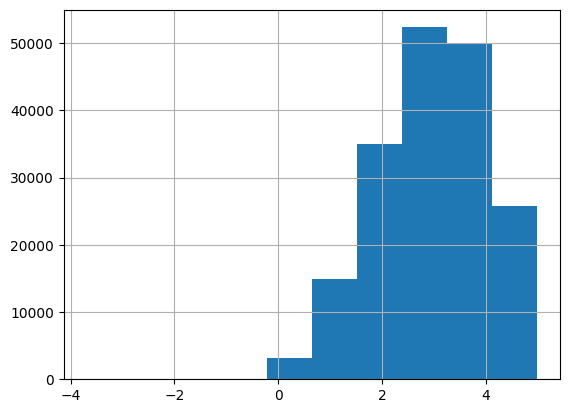

In [34]:
chembl_df=remove_nulls_format(chembl_df, "CX LogP")
chembl_df=chembl_df[chembl_df['CX LogP']<5].reset_index(drop=True)
chembl_df['CX LogP'].hist()

### Filter Hydrogen Bond Acceptors - Donors

In [35]:
chembl_df=chembl_df[(chembl_df['HBA']!='None') & (chembl_df['HBD']!='None')]
chembl_df['HBD']=chembl_df['HBD'].astype(float)
chembl_df['HBA']=chembl_df['HBA'].astype(float)

chembl_df=chembl_df[(chembl_df['HBA'] <=6) & (chembl_df['HBD'] <=6)]
print(f"Newest filtered_df: {len(chembl_df):,}")

Newest filtered_df: 164,964


In [36]:
%%time 
chembl_df['molecule']=chembl_df['Smiles'].apply(lambda x: Chem.MolFromSmiles(x))

CPU times: user 23.3 s, sys: 1.57 s, total: 24.8 s
Wall time: 24.8 s


In [37]:
chembl_df=neutralize(chembl_df, 'molecule')

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Molecular Formula,Smiles,inchikey,None,None,molecule,charge,uncharged_mol,uncharged_smiles,updated_charge
0,CHEMBL2047226,,,Small molecule,0,452.40,4,8,4.93,53.08,...,C23H26BrN5,Brc1ccc(CNc2ccnc(NC3CCN(Cc4ccccc4)CC3)n2)cc1,WOAVNWHCIXCOIZ-UHFFFAOYSA-N,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae7812bdd0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae88d61f20>,Brc1ccc(CNc2ccnc(NC3CCN(Cc4ccccc4)CC3)n2)cc1,0
1,CHEMBL1364151,,,Small molecule,0,314.39,5,6,2.50,54.56,...,C18H22N2O3,Cc1[nH]c2ccccc2c1C(=O)CN1CCC2(CC1)OCCO2,OKIWVYPITFJCJI-UHFFFAOYSA-N,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae77fe89e0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae88d61e40>,Cc1[nH]c2ccccc2c1C(=O)CN1CCC2(CC1)OCCO2,0
2,CHEMBL3303694,,,Small molecule,0,296.41,,,4.15,33.62,...,C19H24N2O,CCCCOc1ccc(C2=NC(C)(C)CN2)c2ccccc12,SVZRFSMLNSZUOY-UHFFFAOYSA-N,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae77fd05f0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae88d61f90>,CCCCOc1ccc(C2=NC(C)(C)CN2)c2ccccc12,0
3,CHEMBL533370,,,Small molecule,0,480.82,,,4.67,61.44,...,C23H24Cl3N3O2,O=C(/C=C/c1ccc(Cl)c(Cl)c1)NC1CCN(CCNC(=O)c2ccc...,RMEXNSQQBFWDTO-FNORWQNLSA-N,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae77fd0eb0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae88d670b0>,O=C(/C=C/c1ccc(Cl)c(Cl)c1)NC1CCN(CCNC(=O)c2ccc...,0
4,CHEMBL2220776,,,Small molecule,0,417.51,,,2.43,69.72,...,C25H27N3O3,Cc1ccc([C@H]2N[C@]3(CCCN(Cc4ccccc4)C3=O)[C@H]3...,CPRAMCRTWJIXRS-QTDDQOEGSA-N,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae77fd0c10>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae88d67120>,Cc1ccc([C@H]2N[C@]3(CCCN(Cc4ccccc4)C3=O)[C@H]3...,0


In [38]:
print("original charge distribution of Chembl molecules:")
display(pd.DataFrame(chembl_df['charge'].value_counts()).sort_index())
print("uncharged charge distribution of Chembl molecules")
display(pd.DataFrame(chembl_df['updated_charge'].value_counts()))

original charge distribution of Chembl molecules:


,charge
0,164952
1,12


uncharged charge distribution of Chembl molecules


,updated_charge
0,164952
1,12


In [ ]:
### no change

In [45]:
print(len(drugbank[drugbank['smiles'].duplicated()]))
print(len(drugbank[drugbank['uncharged_smiles'].duplicated()]))

38
25


In [46]:
len(drugbank)

8334

In [48]:
10000-len(drugbank)

1666

In [49]:
chembl_df_sample=chembl_df.sample(n=1666, random_state=1)
chembl_df_sample.reset_index(drop=True, inplace=True)

In [ ]:
chembl_df

In [50]:
fp_function_columns = chembl_df_sample[['inchikey', 'uncharged_smiles']].values.tolist()

print("First two elements of list:")
fp_function_columns[:2]

# parallelize generation
if __name__ == '__main__':

    pbar = tqdm(total=len(chembl_df_sample)/8)
    dfs_list = Manager().list()
    pool = Pool(processes=8)
    res = pool.map_async(partial(generate_morgan_fp, dfs_list), fp_function_columns)
    res.wait()
    pbar.close()

First two elements of list:


  0%|          | 0/208.25 [00:01<?, ?it/s]213.41it/s]


In [51]:
fp_df = pd.DataFrame(list(dfs_list), columns=['inchikey', 'uncharged_smiles', 'morgan_fp'])  # the final result
fp_df['source']='Chembl'
fp_df.head(2)

,inchikey,uncharged_smiles,morgan_fp,source
0,UAERHQIRMNANGB-UHFFFAOYSA-N,CC(C)(CNCc1ccc(OCc2cscn2)cc1)C(N)=O,0000000000000000000000000000000000000000000000...,Chembl
1,JFXPNMLRCWCZEB-UHFFFAOYSA-N,Fc1ccc(OCCCn2c3c(c4cc(Cl)ccc42)CNCC3)cc1,0000000000000100000000000000000000000000000001...,Chembl


In [52]:
chembl_graphs_df=create_graphs(fp_df, 'uncharged_smiles')
print(f"Length of Chembl dataframe: {len(chembl_graphs_df):,}")
chembl_graphs_df.head()

Length of Chembl dataframe: 1,666


,inchikey,uncharged_smiles,morgan_fp,source,dc_graph
0,UAERHQIRMNANGB-UHFFFAOYSA-N,CC(C)(CNCc1ccc(OCc2cscn2)cc1)C(N)=O,0000000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,JFXPNMLRCWCZEB-UHFFFAOYSA-N,Fc1ccc(OCCCn2c3c(c4cc(Cl)ccc42)CNCC3)cc1,0000000000000100000000000000000000000000000001...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2,HAFNAEDWBQWUEH-UHFFFAOYSA-N,CCOc1cccc(-c2nc(CNCc3ccc(C)cc3)co2)c1,0000000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3,MWELUASPVOJPIC-IAGOWNOFSA-N,O=C(Nc1ccc(Br)cc1)O[C@@H]1C2CCN(CC2)[C@@H]1Cn1...,0000000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4,LSBPGQZSPXOWCV-UHFFFAOYSA-N,CN1C2CCC1CC(NC(=O)N1CC(c3ccccc3)c3ccccc31)C2,0100000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...


In [53]:
chembl_final=chembl_graphs_df.merge(chembl_df, how='left', on=['inchikey', 'uncharged_smiles'])
chembl_final.head()

,inchikey,uncharged_smiles,morgan_fp,source,dc_graph,ChEMBL ID,Name,Synonyms,Type,Max Phase,...,Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,None,None,molecule,charge,uncharged_mol,updated_charge
0,UAERHQIRMNANGB-UHFFFAOYSA-N,CC(C)(CNCc1ccc(OCc2cscn2)cc1)C(N)=O,0000000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...,CHEMBL3553587,,,Small molecule,0,...,319.1354,BASE,C16H21N3O2S,CC(C)(CNCc1ccc(OCc2cscn2)cc1)C(N)=O,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae9988e120>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae38e5c890>,0
1,JFXPNMLRCWCZEB-UHFFFAOYSA-N,Fc1ccc(OCCCn2c3c(c4cc(Cl)ccc42)CNCC3)cc1,0000000000000100000000000000000000000000000001...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...,CHEMBL3287533,,,Small molecule,0,...,358.1248,BASE,C20H20ClFN2O,Fc1ccc(OCCCn2c3c(c4cc(Cl)ccc42)CNCC3)cc1,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae45edef20>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae4750c6d0>,0
2,HAFNAEDWBQWUEH-UHFFFAOYSA-N,CCOc1cccc(-c2nc(CNCc3ccc(C)cc3)co2)c1,0000000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...,CHEMBL1859406,,DNDI65421,Small molecule,0,...,322.1681,NEUTRAL,C20H22N2O2,CCOc1cccc(-c2nc(CNCc3ccc(C)cc3)co2)c1,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae9ca5ceb0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae3d5ee660>,0
3,MWELUASPVOJPIC-IAGOWNOFSA-N,O=C(Nc1ccc(Br)cc1)O[C@@H]1C2CCN(CC2)[C@@H]1Cn1...,0000000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...,CHEMBL193743,,,Small molecule,0,...,404.0848,NEUTRAL,C18H21BrN4O2,O=C(Nc1ccc(Br)cc1)O[C@@H]1C2CCN(CC2)[C@@H]1Cn1...,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fadd0e1d3c0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae57868f90>,0
4,LSBPGQZSPXOWCV-UHFFFAOYSA-N,CN1C2CCC1CC(NC(=O)N1CC(c3ccccc3)c3ccccc31)C2,0100000000000000000000000000000000000000000000...,Chembl,<deepchem.feat.mol_graphs.ConvMol object at 0x...,CHEMBL292209,,,Small molecule,0,...,361.2154,BASE,C23H27N3O,CN1C2CCC1CC(NC(=O)N1CC(c3ccccc3)c3ccccc31)C2,None,None,<rdkit.Chem.rdchem.Mol object at 0x7fae9be8fac0>,0,<rdkit.Chem.rdchem.Mol object at 0x7fae3a9a1270>,0


In [56]:
resave=True

if resave:
    file_name="/home/paperspace/Desktop/DL_Project/data/chembl_sample_fp_graphs.pickle"
    # save it with the graphs (large file)
    chembl_final.to_pickle(file_name, compression='infer', storage_options=None)

### Combine Chembl and Drugbank for Full Prediction Set

In [57]:
chembl_final=chembl_final[['inchikey', 'uncharged_smiles', 'morgan_fp', 'source', 'uncharged_mol', 'molecule', 'dc_graph']]
drugbank_final=drugbank_final[['inchikey', 'uncharged_smiles', 'morgan_fp', 'source', 'uncharged_mol', 'molecule', 'dc_graph']]

In [58]:
full_pred_set=pd.concat([drugbank_final, chembl_final]).reset_index(drop=True)
print(f"Length of full prediction set: {len(full_pred_set):,}")
full_pred_set.head()

Length of full prediction set: 10,008


,inchikey,uncharged_smiles,morgan_fp,source,uncharged_mol,molecule,dc_graph
0,NGVDGCNFYWLIFO-UHFFFAOYSA-N,Cc1ncc(COP(=O)(O)O)c(C=O)c1O,0000000000000000000000000000000000000000000000...,Drugbank,<rdkit.Chem.rdchem.Mol object at 0x7fb0074120b0>,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a54a0>,<deepchem.feat.mol_graphs.ConvMol object at 0x...
1,DFEYYRMXOJXZRJ-UHFFFAOYSA-N,FCOC(C(F)(F)F)C(F)(F)F,0100000000000000000000000000000000000000000000...,Drugbank,<rdkit.Chem.rdchem.Mol object at 0x7faf3ba76900>,<rdkit.Chem.rdchem.Mol object at 0x7fafc5e7b4a0>,<deepchem.feat.mol_graphs.ConvMol object at 0x...
2,RKNHJBVBFHDXGR-MRUDJCSFSA-N,[H]/N=c1\c2ncn([C@@H]3O[C@H](CO[P@](=O)(O)O[P@...,0000000000000000000000000000000000000000000000...,Drugbank,<rdkit.Chem.rdchem.Mol object at 0x7faf38e444a0>,<rdkit.Chem.rdchem.Mol object at 0x7faf3b9a7580>,<deepchem.feat.mol_graphs.ConvMol object at 0x...
3,WHBIGIKBNXZKFE-UHFFFAOYSA-N,CC(C)Nc1cccnc1N1CCN(C(=O)c2cc3cc(NS(C)(=O)=O)c...,0100000000000000000000000000000000000000000000...,Drugbank,<rdkit.Chem.rdchem.Mol object at 0x7faf3a1864a0>,<rdkit.Chem.rdchem.Mol object at 0x7fafc6131190>,<deepchem.feat.mol_graphs.ConvMol object at 0x...
4,MSTNYGQPCMXVAQ-KIYNQFGBSA-N,Nc1nc(=O)c2c([nH]1)NC[C@H](CNc1ccc(C(=O)N[C@@H...,0100000000001000000000000000000000000000000000...,Drugbank,<rdkit.Chem.rdchem.Mol object at 0x7fb007412c80>,<rdkit.Chem.rdchem.Mol object at 0x7fb0076a5660>,<deepchem.feat.mol_graphs.ConvMol object at 0x...


In [59]:
resave=True

if resave:
    file_name="/home/paperspace/Desktop/DL_Project/data/full_prediction_set_fp_graphs.pickle"
    # save it with the graphs (large file)
    full_pred_set.to_pickle(file_name, compression='infer', storage_options=None)

The tight gap allows only passive diffusion of lipid-soluble drugs at a molecular weight lower than 400-600 Da. Increasing lipophilicity of the therapeutic agents is a feasible method to improve the BBB permeabil

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3260741/